<a href="https://colab.research.google.com/github/vivalladarez/text-classification-rnn/blob/main/Sentiment-Classifier-RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MVP - Machine Learning & Analytics

Este projeto corresponde ao MVP da terceira sprint do curso de Pós-Graduação em Ciência de Dados e Analytics da PUC-Rio.


### **Problemática**

O problema abordado neste projeto é a criação de um classificador de sentimentos utilizando um modelo de Deep Learning baseado em redes neurais recorrentes (RNN), com dados provenientes de avaliações de aplicativos disponíveis na Google Play Store.

O objetivo deste trabalho é construir um modelo eficaz capaz de analisar automaticamente as avaliações dos usuários e atribuir a elas uma classificação de sentimento (positivo/negativo). Isso fornecerá insights valiosos para os desenvolvedores e empresas sobre a percepção de seus produtos pelos usuários.

### **Dataset**

**App Reviews**: dataset de análises dos usuários nos aplicativos da Google Play Store, para cada avaliação textual é atribuido uma classificação numérica de 1 a 5, que reflete o nível de satisfação dos usuários com o aplicativo.

**Atributos Utilizados**:

`content`: Descritivo da avaliação do usuário para o aplicativo

`score`: Nota de 0 a 5 para o mesmo app






# Setup

In [65]:
#!pip install google_play_scraper
#pip install tensorflow

import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import nltk

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding

import warnings
warnings.filterwarnings('ignore')

# Download dos recursos do NLTK
nltk.download('punkt')
nltk.download('stopwords')

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

#from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

tfds.disable_progress_bar()

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Coleta de Dados


Ao construir um classificador de sentimentos, é fundamental contar com um
conjunto de dados rotulados. Uma fonte valiosa de informações são as análises dos usuários nos aplicativos da Google Play Store.

**Google-Play-Scraper**

Nestas análises, cada texto é atribuído a uma classificação numérica de 1 a 5, que reflete o nível de satisfação dos usuários com as aplicações e, por conseguinte, seus sentimentos em relação às suas experiências.


In [3]:
"""
#Definindo os IDs dos aplicativos escolhidos para a extração das avaliações

apps_ids = ['br.com.brainweb.ifood', 'com.grability.rappi', 'com.ubercab.eats',

'com.mcdo.mcdonalds', 'burgerking.com.br.appandroid', 'com.vanuatu.aiqfome']

#Extraindo informações básicas para cada aplicativo

app_infos = []

for ap in tqdm(apps_ids):
    info = app(ap, lang='en', country='us')
    del info['comments']
    app_infos.append(info)

app_reviews = []

#Selecionou-se 400 amostras de avaliações com score 3 e 700 de cada uma das outras.

for ap in tqdm(apps_ids):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='pt',
                country='br',
                sort=sort_order,
                count= 400 if score == 3 else 700,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            app_reviews.extend(rvs)

df = pd.DataFrame(app_reviews)

app_infos_df = pd.DataFrame(app_infos)
app_infos_df.head(2)

df.to_csv('app_reviews.csv', index=False)"""


print("Bloco de códico utilizad0 para coleta de dados")
print("/n Realizou-se a extração e seu upload no github")

Bloco de códico utilizad0 para coleta de dados
/n Realizou-se a extração e seu upload no github


Uma vez executado o código comentado da celula anterior, o arquivo .csv foi salvo em um repositório do github para apontamento direto por url.

In [51]:
#Import do arquivo trips_data.csv disponibilizao no github
url = 'https://raw.githubusercontent.com/vivalladarez/text-classification-rnn/main/app_reviews.csv'

# Criação do dataframe
df = pd.read_csv(url)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,678ba8c7-487e-4f6d-be71-12451dbd33dc,Bruna Serafim,https://play-lh.googleusercontent.com/a-/ALV-U...,"Para compras em mercados, vale mais a pena se ...",1,801,10.10.0,2024-03-23 23:53:38,NaN,NaN,10.10.0,most_relevant,br.com.brainweb.ifood
1,5f40e723-9a35-4f29-8541-3b915a64374a,Ander son,https://play-lh.googleusercontent.com/a/ACg8oc...,Aplicativo horrível! Se não querem ficar nervo...,1,392,10.7.1,2024-03-01 20:01:02,NaN,NaN,10.7.1,most_relevant,br.com.brainweb.ifood
2,c1ced2fe-67c0-4135-915d-00fecd4c7345,Anne Dias,https://play-lh.googleusercontent.com/a-/ALV-U...,Eu gosto muito de fazer compras no mercado pel...,1,1040,10.7.1,2024-03-04 21:31:53,NaN,NaN,10.7.1,most_relevant,br.com.brainweb.ifood
3,3b09c1b6-58ed-40f0-a4c9-22a910ffdedf,Leon Tomelin,https://play-lh.googleusercontent.com/a-/ALV-U...,"Nos últimos meses, o aplicativo piorou demais....",1,3182,9.237.0,2023-12-13 23:18:59,NaN,NaN,9.237.0,most_relevant,br.com.brainweb.ifood
4,98bcb103-906b-4df4-a5db-97f34b60bc9f,Mika Souza,https://play-lh.googleusercontent.com/a-/ALV-U...,"Estou tendo problemas com cupons, toda vez que...",1,1141,9.230.0,2023-11-14 14:33:03,NaN,NaN,9.230.0,most_relevant,br.com.brainweb.ifood


# Análise e Pré-processamento do Dataset

Este processo abrange diversas etapas cruciais para assegurar a qualidade e a eficácia do modelo, incluindo:

* Análise dos Dados
* Limpeza dos Dados
* Divisão em conjuntos de treinamento e teste


## Análise de Dados

Analisou-se a distribuição da amostra por score e padrões ou tendências específicas associadas a cada uma delas.

**`score 1`**: avaliações predominatemente negativas;

**`score 3`**: avaliações avaliações ambíguas: "Aplicativo ; bom, mas lento"; "A comida é boa, mas o fato de não da pra pagar...";

**`score 4`**: avaliações predominatemente positivas.


In [52]:
# Contagem de valores únicos na coluna 'score'
score_counts = df['score'].value_counts()

print("Contagem de Valores Únicos na Coluna 'score':")
print("\n------------------")
print(score_counts)
print("\n------------------")

df_reviews = df[['content', 'score']]

# Selecionar duas amostras de classe 1
df_score_1 = df_reviews[df['score'] == 1].sample(2)

# Selecionar duas amostras de classe 3
df_score_3 = df_reviews[df['score'] == 3].sample(2)

# Selecionar duas amostras de classe 5
df_score_5 = df_reviews[df['score'] == 5].sample(2)

# Concatenar os dataframes selecionados
df_selected_samples = pd.concat([df_score_3, df_score_1, df_score_5])

# Exibir o dataframe resultante
print(df_selected_samples)

Contagem de Valores Únicos na Coluna 'score':

------------------
score
5    5586
4    4879
2    4680
1    3781
3    3592
Name: count, dtype: int64

------------------
                                                 content  score
1699   App quase nunca me deixa compra pelo o meu car...      3
1717   O aplicativo funcionava muito bem,só foi eu tr...      3
12632  Estou extremamente decepcionada , o aplicativo...      1
18941  PÉSSIMO! Estou a horas tentando conectar ao Fa...      1
18395                                              otimo      5
11835  Tem bem mais vantagem que o Ifood , como por e...      5


##Limpeza dos dados

Essa etapa visa garantir a consistência e a qualidade dos dados antes da análise de sentimentos.

**Remover informações ruidosas e unificação dos dados:**

*   Eliminar avaliações ambíguas, derivadas do score 3
*   Reduzir as classes para duas: 0 (sentimentos negativos) ou 1 (sentimentos postivos).
*   Remover caracteres especiais, pontuações e símbolos;
*   Padronizar o texto, convertendo-o para minúsculas e removendo espaços em branco adicionais.
*   Remover de stopwords, isto é, palavras comuns que geralmente não contribuem para o significado de uma frase;
* Aplicar  stemming, isto é, reduzir as palavras às suas formas radicais ou raízes.




In [53]:
# Elinar amsotras de score 3 e Redução de Classes

df = df[~df['score'].isin([3])]

# Atribuir valor 0 para avaliações negativas <=2 e 1 para positivas
def map_score(rating):
    if rating <= 2:
        return 0
    else:
        return 1

# Aplicando a função ao DataFrame
df['score'] = df['score'].apply(map_score)

df_reviews = df[['content', 'score']]
df_reviews

,content,score
0,"Para compras em mercados, vale mais a pena se ...",0
1,Aplicativo horrível! Se não querem ficar nervo...,0
2,Eu gosto muito de fazer compras no mercado pel...,0
3,"Nos últimos meses, o aplicativo piorou demais....",0
4,"Estou tendo problemas com cupons, toda vez que...",0
...,...,...
22513,Vacilita muito nossa vida...,1
22514,Não tenho ainda,1
22515,"O app é perfeito, muitas promos exclusivas do ...",1
22516,"Muito boa, pra mim minhas compras chega rápido...",1


In [54]:
# Função para remoção de pontuações e caracteres especiais
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Função para normalização de texto (converter para minúsculas)
def normalize_text(text):
    return text.lower()

# Função para remoção de stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Função para aplicar stemming
def apply_stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

# Aplicando os passos ao DataFrame df_reviews
df_reviews['content'] = df_reviews['content'].apply(remove_special_characters)
df_reviews['content'] = df_reviews['content'].apply(normalize_text)
df_reviews['content'] = df_reviews['content'].apply(remove_stopwords)
df_reviews['content'] = df_reviews['content'].apply(apply_stemming)


In [55]:
# Contagem de valores únicos na coluna 'score'
score_counts = df_reviews['score'].value_counts()

print("Contagem de Valores Únicos na Coluna 'score':")
print(score_counts)

Contagem de Valores Únicos na Coluna 'score':
score
1    10465
0     8461
Name: count, dtype: int64


## Treino e Teste

In [56]:
# Dividir os dados em conjunto de treinamento e teste
train_df, test_df = train_test_split(df_reviews, test_size=0.2, random_state=42)

# Preparar os dados para treinamento
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['content'].values, train_df['score'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['content'].values, test_df['score'].values))

# Verificar a especificação do elemento
print(train_dataset.element_spec)


(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [57]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'app abr'
label:  0


**BUFFER SIZE e BATCH_SIZE**

Essas linhas definem dois parâmetros importantes para o treinamento de modelos de aprendizado de máquina: **`BUFFER_SIZE`** controla o tamanho do buffer usado para embaralhar os dados durante o treinamento, enquanto **`BATCH_SIZE`** define o número de exemplos de treinamento processados em cada iteração de treinamento.

In [58]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

#Preparação do conjunto de dados para o embaralhamento e tamanho
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

**TextVectorization**

Criação de um objeto TextVectorization no TensorFlow Keras para converter texto em vetores numéricos. O parâmetro max_tokens define o tamanho máximo do vocabulário, ou seja, o número máximo de palavras únicas consideradas durante a tokenização. O método adapt é usado para ajustar o vetorizador aos dados de treinamento, construindo um vocabulário com base nessas amostras. Isso garante que o vetorizador atribua um índice único para cada palavra no conjunto de treinamento, facilitando a conversão de texto em representações numéricas.

In [61]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

#Array contendo o vocabulário obtido do vetorizador do texto
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

In [63]:
#Codificação um exemplo de texto usando o vetorizador de texto
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[107, 247,  70,   1,  11, 109,  22, 117,   8,  20, 435,   3, 274,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [273,   1, 107,   9,  67, 798, 715,   5,   3,  40,  47,   7,  35,
          1, 150,   2, 181, 459, 442,   7, 643,   4,  55, 246,  72, 138,
          8, 689,  19,  46,   1,  39,   1,  16, 585,   2, 186,  38, 130,
          1,   1, 725,   5,  91,   1, 931, 264,  40, 282,  35,   1, 585,
          3,  78, 631, 114,   1,   1,   2,  28, 278,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0

In [64]:
#Impressão dos exemplos originais e suas correspondentes palavras codificadas, utilizando o vocabulário obtido do vetorizador de texto
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'h grand promo abrangent em ope eu acho muito bom acesso e sua funcionabilidad'
Round-trip:  h grand promo [UNK] em ope eu acho muito bom acesso e sua [UNK]                                                            

Original:  b'fiquei surpreso h um tempo atr baixei app e ao fazer pedido ele calcul endereo de ond trabalho logo pedido teve que ser cancelado poi estava muito long da minha residncia foi gerado uma dvida de quas como fui culpado obviament cancelei app porm resolvi baixar novament ao reclamar ele tiram dvida e ainda deram crdito verdadeiro solicionador de problema parabn'
Round-trip:  fiquei [UNK] h um tempo atr baixei app e ao fazer pedido ele [UNK] endereo de ond trabalho logo pedido teve que ser cancelado poi estava muito long da minha [UNK] foi [UNK] uma dvida de quas como fui [UNK] [UNK] cancelei app porm [UNK] baixar novament ao reclamar ele [UNK] dvida e ainda deram crdito [UNK] [UNK] de problema parabn             

Original:  b'brutal'
Round-trip:  [U

# Criação do Modelo
Vamos utilizar um modelo bidirecional, que consiste em uma arquitetura de rede neural amplamente utilizada no campo do aprendizado de máquina, especialmente em tarefas relacionadas ao processamento de linguagem natural (PLN) e modelagem de sequência. Essa arquitetura consiste em duas redes neurais recorrentes (RNNs) distintas, que processam a sequência de entrada em direções opostas: direta e reversa.


## Avaliação de Hiperparâmetros


In [ ]:
# Tamanho do lote (batch size)
batch_size = 32

# Lista de hiperparâmetros para testar
epochs_list = [5, 10]
lstm_units_list = [64, 128]
activation_functions = ['relu', 'sigmoid', 'tanh']

train_dataset = tf.data.Dataset.from_tensor_slices((train_df['content'].values, train_df['score'].values)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['content'].values, test_df['score'].values)).batch(batch_size)

best_accuracy = 0
best_params = {}

# Dicionário para armazenar as métricas de validação para cada combinação de hiperparâmetros
validation_metrics = {}

# Loop através dos hiperparâmetros
for epochs in epochs_list:
    for lstm_units in lstm_units_list:
        for activation_function in activation_functions:
            print(f"Testing with {epochs} epochs, {lstm_units} LSTM units, and {activation_function} activation function")

            # Construa o modelo
            model = Sequential([
                encoder,
                Embedding(
                    input_dim=len(encoder.get_vocabulary()),
                    output_dim=64,
                    mask_zero=True),
                Bidirectional(LSTM(lstm_units)),
                Dense(64, activation=activation_function),
                Dense(1)
            ])

            model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
            )

            history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, verbose=0)

            _, accuracy = model.evaluate(test_dataset)
            print(f"Validation Accuracy: {accuracy:.4f}")

            # Salvamento dos hiperparâmetros
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'epochs': epochs, 'lstm_units': lstm_units, 'activation_function': activation_function}

            validation_metrics[(epochs, lstm_units, activation_function)] = history.history['val_accuracy']

print("Melhor Acurácia de Validação:", best_accuracy)
print("Melhores Parâmetros:", best_params)

# plot
plt.figure(figsize=(10, 6))


for params, val_accuracy in validation_metrics.items():
    epochs, lstm_units, activation_function = params
    label = f'{epochs} épocas, {lstm_units} unidades LSTM, função de ativação {activation_function}'
    plt.plot(val_accuracy, label=label, linewidth=2)

plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Acurácia de Validação', fontsize=14)
plt.title('Acurácia de Validação para Diferentes Hiperparâmetros', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.ylim(bottom=0.5)
plt.tight_layout()
plt.show()


Testing with 5 epochs, 64 LSTM units, and relu activation function
119/119 [==============================] - 5s 41ms/step - loss: 0.5497 - accuracy: 0.8114
Validation Accuracy: 0.8114
Testing with 5 epochs, 64 LSTM units, and sigmoid activation function
119/119 [==============================] - 3s 23ms/step - loss: 6.9842 - accuracy: 0.5420
Validation Accuracy: 0.5420
Testing with 5 epochs, 64 LSTM units, and tanh activation function
119/119 [==============================] - 3s 24ms/step - loss: 0.4606 - accuracy: 0.8122
Validation Accuracy: 0.8122
Testing with 5 epochs, 128 LSTM units, and relu activation function
119/119 [==============================] - 7s 63ms/step - loss: 0.6026 - accuracy: 0.8516
Validation Accuracy: 0.8516
Testing with 5 epochs, 128 LSTM units, and sigmoid activation function
119/119 [==============================] - 7s 58ms/step - loss: 0.4623 - accuracy: 0.8428
Validation Accuracy: 0.8428
Testing with 5 epochs, 128 LSTM units, and tanh activation function

## Sequential Neural Network (SNN)

* TextVectorization (encoder): Esta camada converte o texto em números, tokenizando-o e transformando-o em sequências de números.
* Embedding: camada que epresenta as palavras como vetores densos em um espaço de incorporação, permitindo que o modelo aprenda representações distribuídas das palavras.
* Camada LSTM Bidirecional: Processa a entrada em ambas as direções (esquerda para direita e direita para esquerda), capturando informações contextuais tanto do passado quanto do futuro.
* Camada Densa: Possui 64 unidades neurais com função de ativação ReLU, aprendendo padrões complexos nos dados de entrada.
* Camada de Saída Densa: Produz uma única saída, adequada para problemas de classificação binária (positivo ou negativo), sem uma função de ativação específica definida.



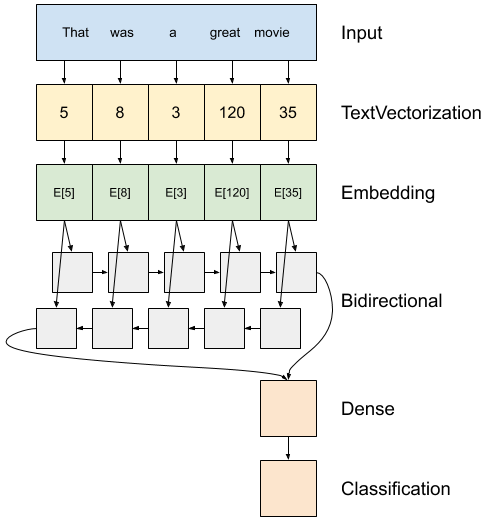



In [60]:
#Construção do Modelo
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Mascaramento para lidar com os comprimentos variáveis das sequências
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [61]:
#Cada valor na lista corresponde a uma camada do modelo e indica se essa camada suporta mascaramento (True)/(False).
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [62]:
# Previsão com um texto sem preenchimento

sample_text = ('Muito bom'
               'Muito Ruim')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00776147]


In [63]:
# Previsão com preenchimento

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 273ms/step
[0.00776147]


In [64]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [65]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
176/176 [==============================] - 37s 157ms/step - loss: 0.6697 - accuracy: 0.4056 - val_loss: 0.6067 - val_accuracy: 0.6302
Epoch 2/10
176/176 [==============================] - 25s 141ms/step - loss: 0.4438 - accuracy: 0.7928 - val_loss: 0.3861 - val_accuracy: 0.8344
Epoch 3/10
176/176 [==============================] - 27s 153ms/step - loss: 0.3243 - accuracy: 0.8697 - val_loss: 0.3386 - val_accuracy: 0.8495
Epoch 4/10
176/176 [==============================] - 25s 140ms/step - loss: 0.2827 - accuracy: 0.8840 - val_loss: 0.3112 - val_accuracy: 0.8594
Epoch 5/10
176/176 [==============================] - 25s 141ms/step - loss: 0.2535 - accuracy: 0.8928 - val_loss: 0.3010 - val_accuracy: 0.8630
Epoch 6/10
176/176 [==============================] - 25s 139ms/step - loss: 0.2371 - accuracy: 0.8970 - val_loss: 0.2901 - val_accuracy: 0.8635
Epoch 7/10
176/176 [==============================] - 24s 138ms/step - loss: 0.2259 - accuracy: 0.9023 - val_loss: 0.2887 - val_ac

(0.0, 0.692791261523962)

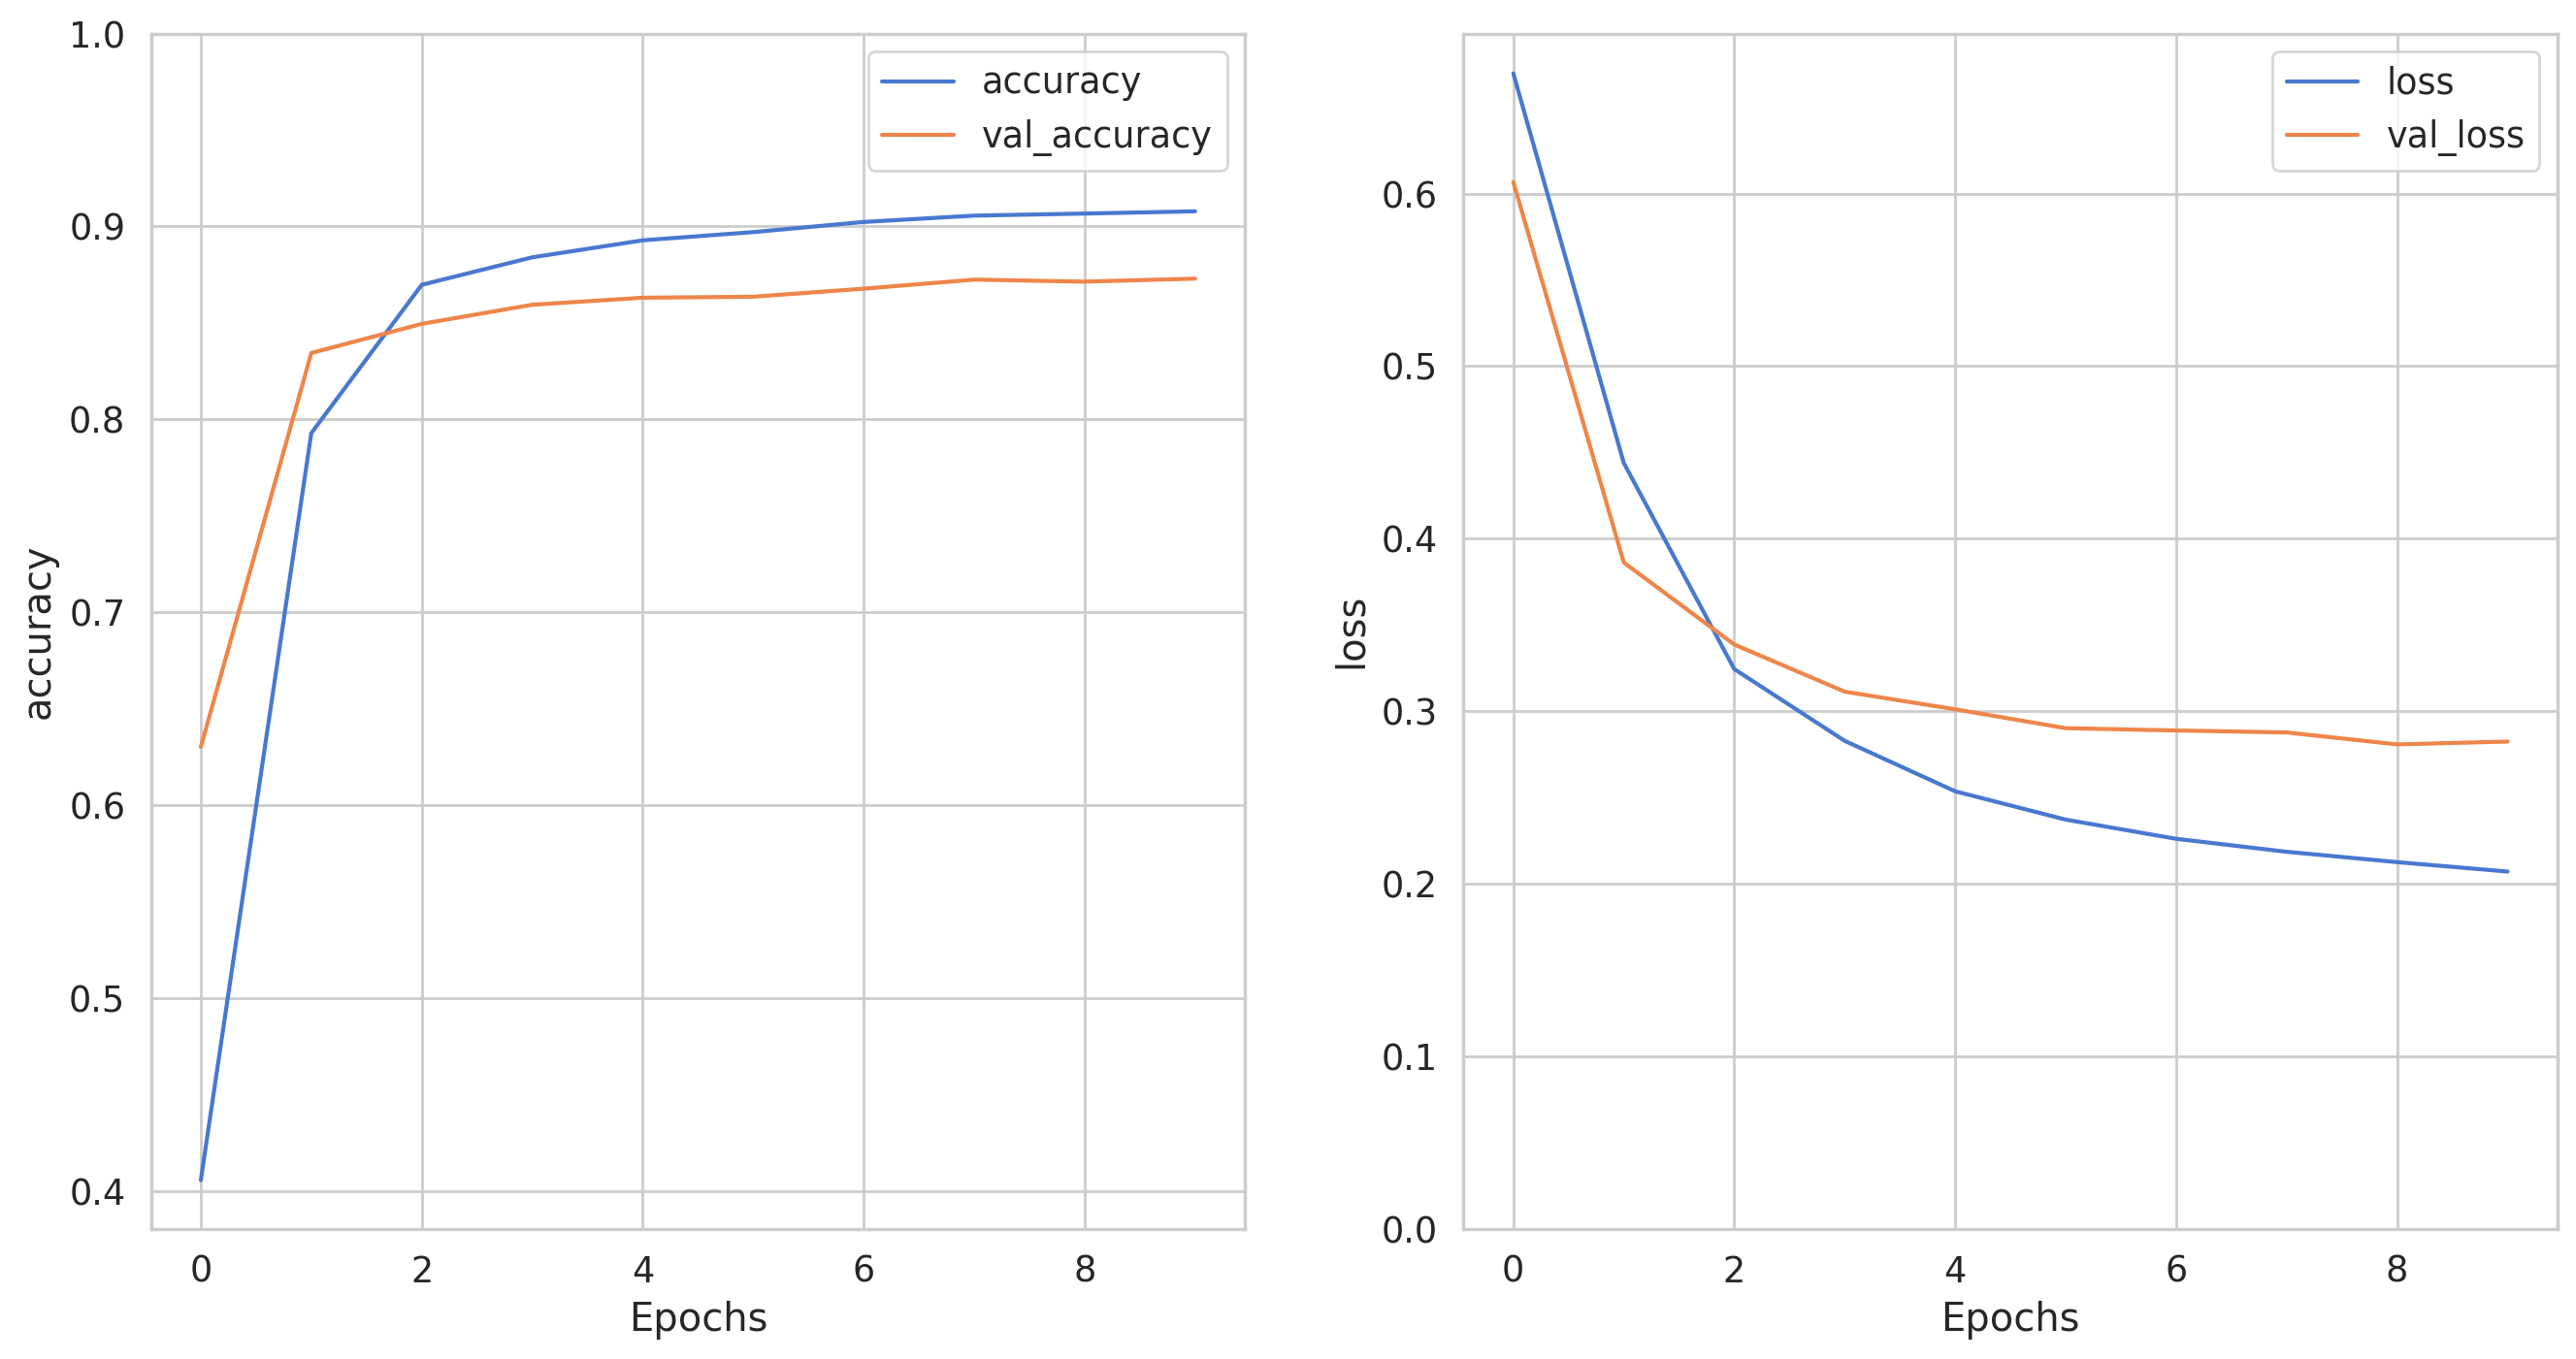

In [72]:
# Grafico de Accuracy e Loss

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

print("\n------------------")


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [69]:
#Teste do Modelo

# Input do usuário
sample_text = input("Digite o texto para realizar a previsão: ")

# Realizar a predição no texto de exemplo sem padding
predictions = model.predict(np.array([sample_text]))

# Imprimir a previsão
print("Previsão:", predictions)

# Escrever a sentença com base na previsão
if predictions >= 1:
    print("A previsão é positiva.")
else:
    print("A previsão é negativa.")

1/1 [==============================] - 3s 3s/step
Previsão: [[7.0964327]]
A previsão é positiva.


## Recurrent Neural Network (RNN) - Empilhamento de duas camadas LSTM

As camadas recorrentes de Keras têm dois modos disponíveis que são controlados pelo argumento do construtor `return_sequences`:

* Se `False` retorna apenas a última saída para cada sequência de entrada (um tensor 2D de forma (batch_size, output_features)). Este é o padrão, usado no modelo anterior.

* Se `True` as sequências completas de saídas sucessivas para cada timestep são retornadas (um tensor 3D de forma `(batch_size, timesteps, output_features)`).

Aqui está a aparência do fluxo de informações com `return_sequences=True`:


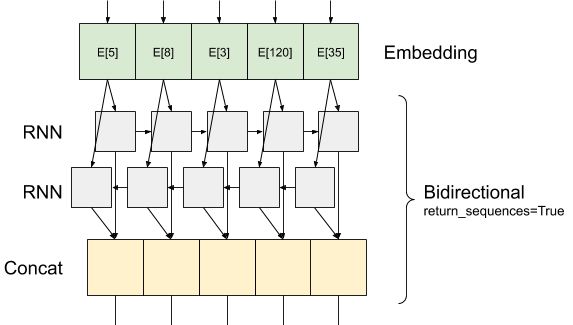

Este modelo é projetado para lidar com dados sequenciais, como texto, e capturar informações de contexto usando camadas LSTM bidirecionais, seguidas por camadas densas para processamento e classificação final.

In [24]:
#Empilhamento de duas camadas LSTM

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
60/60 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.4984

60/60 [==============================] - 43s 385ms/step - loss: 0.6895 - accuracy: 0.4984 - val_loss: 0.6823 - val_accuracy: 0.5047
Epoch 2/10
60/60 [==============================] - 15s 248ms/step - loss: 0.6667 - accuracy: 0.4984
Epoch 3/10
60/60 [==============================] - 15s 246ms/step - loss: 0.5942 - accuracy: 0.5102
Epoch 4/10
60/60 [==============================] - 18s 295ms/step - loss: 0.4697 - accuracy: 0.6936
Epoch 5/10
60/60 [==============================] - 16s 271ms/step - loss: 0.3833 - accuracy: 0.7891
Epoch 6/10
60/60 [==============================] - 15s 251ms/step - loss: 0.3337 - accuracy: 0.8432
Epoch 7/10
60/60 [==============================] - 15s 244ms/step - loss: 0.2911 - accuracy: 0.8894
Epoch 8/10
60/60 [==============================] - 15s 251ms/step - loss: 0.2623 - accuracy: 0.9110
Epoch 9/10
60/60 [==============================] - 15s 245ms/step - loss: 0.2401 - accuracy: 0.9212
Epoch 10/10
60/60 [==============================] - 15s 245

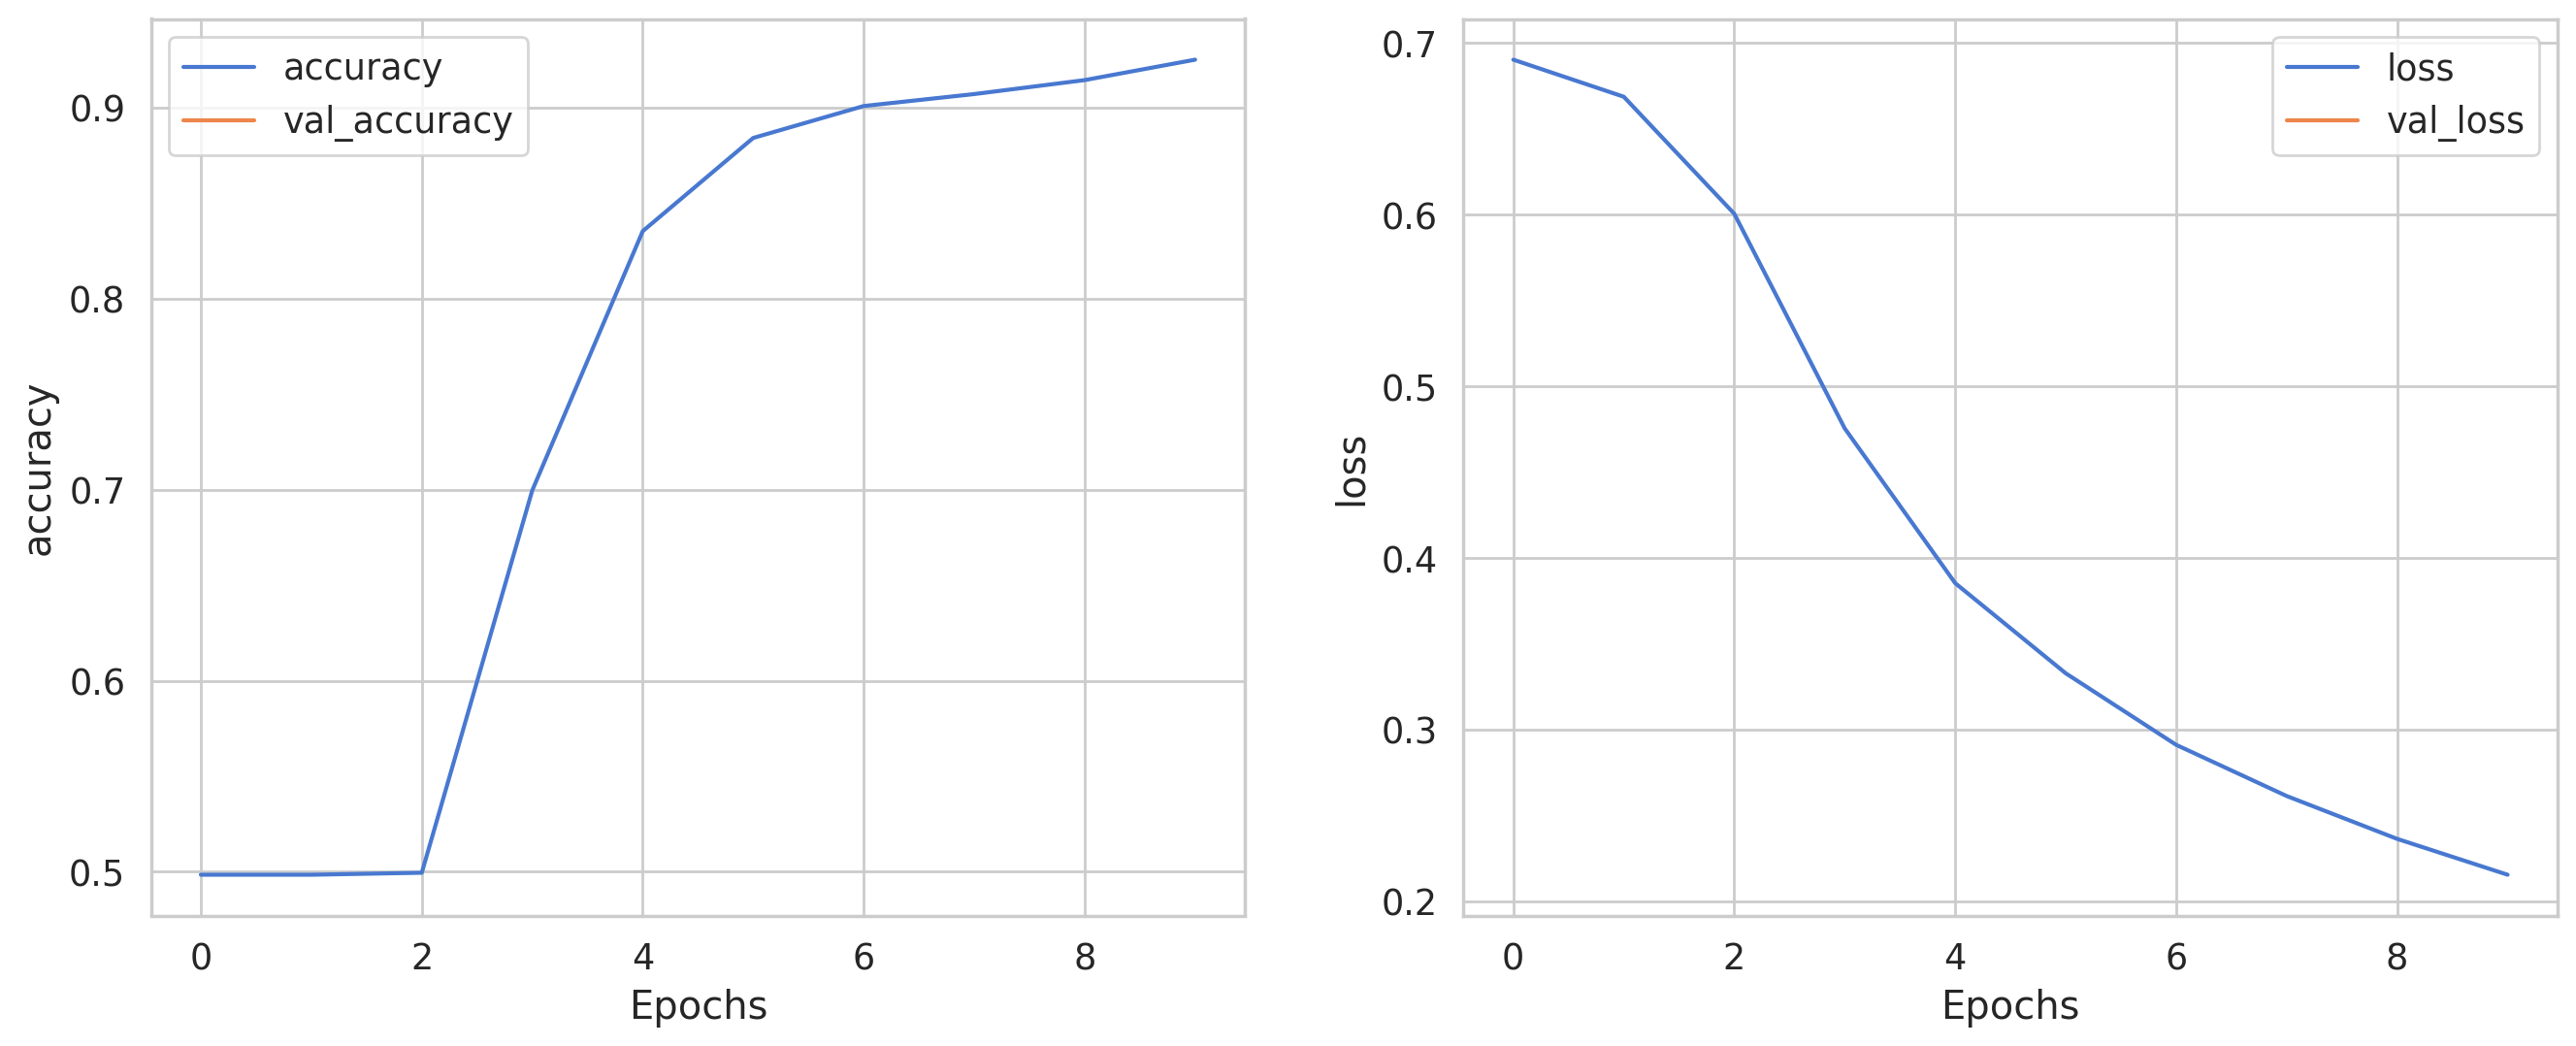

In [38]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

print("\n------------------")

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
#Teste do Modelo

# Input do usuário
sample_text = input("Digite o texto para realizar a previsão: ")

# Realizar a predição no texto de exemplo sem padding
predictions = model.predict(np.array([sample_text]))

# Imprimir a previsão
print("Previsão:", predictions)

# Escrever a sentença com base na previsão
if predictions >= 1:
    print("A previsão é positiva.")
else:
    print("A previsão é negativa.")